In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import os

# Interactive plotting
# %matplotlib widget

plt.style.use("ggplot")

# Estimate river fluxes

Taking clean river discharge data (output of notebook q2_clean_discharge_data) and estimated daily concentrations of the variables of interest (from notebook flux2). Multiply these together (taking care of the units) to estimate daily, monthly and annual fluxes to the Oslofjord from the three big rivers.

**Discuss with Helene how to save the results.** E.g. one csv per river of daily fluxes?

Also plot daily, monthly and annual fluxes

## Read in

In [2]:
df_water_chem = pd.read_csv('../../data/river/water_chem/estimations/water_chem_daily_estimations.csv')
df_water_chem

station_name        Date  discharge  Farge_mg Pt/l_raw  \
0      Drammenselva v/Krokstadelva  1990-01-01    264.681                NaN   
1      Drammenselva v/Krokstadelva  1990-01-02    264.681                NaN   
2      Drammenselva v/Krokstadelva  1990-01-03    260.214                NaN   
3      Drammenselva v/Krokstadelva  1990-01-04    260.214                NaN   
4      Drammenselva v/Krokstadelva  1990-01-05    260.214                NaN   
...                            ...         ...        ...                ...   
37969          Numedalslågen v/E18  2024-08-23    155.641                NaN   
37970          Numedalslågen v/E18  2024-08-24    199.478                NaN   
37971          Numedalslågen v/E18  2024-08-25    213.277                NaN   
37972          Numedalslågen v/E18  2024-08-26    192.718                NaN   
37973          Numedalslågen v/E18  2024-08-27    148.680                NaN   

       Farge_mg Pt/l_est  DIN_μg/l_raw  DIN_μg/l_est  PO4-P_µg/l_raw  \
0                    NaN           NaN           NaN             NaN   
1                    NaN           NaN           NaN             NaN   
2                    NaN           NaN           NaN             NaN   
3                    NaN           NaN           NaN             NaN   
4                    NaN           NaN           NaN             NaN   
...                  ...           ...           ...             ...   
37969               37.0           NaN         155.0             NaN   
37970               37.0           NaN         155.0             NaN   
37971               37.0           NaN         155.0             NaN   
37972               37.0           NaN         155.0             NaN   
37973               37.0           NaN         155.0             NaN   

       PO4-P_µg/l_est  SiO2_mg/l_raw  ...  TOTP_P_µg/l P_raw  \
0                 NaN            NaN  ...                NaN   
1                 NaN            NaN  ...                NaN   
2                 NaN            NaN  ...                NaN   
3                 NaN            NaN  ...                NaN   
4                 NaN            NaN  ...                NaN   
...               ...            ...  ...                ...   
37969             2.0            NaN  ...                NaN   
37970             2.0            NaN  ...                NaN   
37971             2.0            NaN  ...                NaN   
37972             2.0            NaN  ...                NaN   
37973             2.0            NaN  ...                NaN   

       TOTP_P_µg/l P_est  TOTP_µg/l_raw  TOTP_µg/l_est  TSM_mg/l_raw  \
0                    NaN            NaN            NaN           NaN   
1                    NaN            NaN            NaN           NaN   
2                    NaN            NaN            NaN           NaN   
3                    NaN            NaN            NaN           NaN   
4                    NaN            NaN            NaN           NaN   
...                  ...            ...            ...           ...   
37969                6.6            NaN            7.8           NaN   
37970                6.6            NaN            7.8           NaN   
37971                6.6            NaN            7.8           NaN   
37972                6.6            NaN            7.8           NaN   
37973                6.6            NaN            7.8           NaN   

       TSM_mg/l_est  UV-Abs. 410nm_Abs/cm_raw  UV-Abs. 410nm_Abs/cm_est  \
0               NaN                       NaN                       NaN   
1               NaN                       NaN                       NaN   
2               NaN                       NaN                       NaN   
3               NaN                       NaN                       NaN   
4               NaN                       NaN                       NaN   
...             ...                       ...                       ...   
37969          2.91                  

In [8]:
# LJB: don't think we need this. Just do for all present in the df (more generalisable then)
# To do: _raw and _est is a bit messy. Move that to a separate "research" notebook? Version for galaxy should just be daily estimated I think

# variables = ['DIN_μg/l_raw', 'DIN_μg/l_est', 'PO4-P_µg/l_raw',
#              'PO4-P_µg/l_est', 'SiO2_mg/l_raw', 'SiO2_mg/l_est', 'TOC_mg/l_raw',
#              'TOC_mg/l_est', 'TOTN_µg/l_raw', 'TOTN_µg/l_est', 'TOTP/F_µg/l P_raw',
#              'TOTP/F_µg/l P_est', 'TOTP_P_µg/l P_raw', 'TOTP_P_µg/l P_est',
#              'TOTP_µg/l_raw', 'TOTP_µg/l_est', 'TSM_mg/l_raw', 'TSM_mg/l_est']

site_li = df_water_chem['station_name'].unique()

short_site_li = {'Drammenselva v/Krokstadelva': 'Drammenselva',
                 'Glomma v/Sarpefossen': 'Glomma',
                 'Numedalslågen v/E18': 'Numedalslagen'
}

In [22]:
# Extract data for each site and store in dictionary, setting datetime index

# LJB: instead of doing for each river separately and calling dfs glomma_df, etc., it's more flexible to 
# make a dictionary, loop through sites, save results in the dict (e.g. if we end up with 10 sites later, or site names change)
# Same for daily, monthly and annual fluxes, so I quickly altered that code below too. I sorted the date column out here
# (save to index), so we don't have to worry about doing that multiple times below)

chem_df_dict = {}

for site in site_li:
    chem_station_df = df_water_chem[df_water_chem['station_name'] == site].copy()
    
    if 'Date' not in chem_station_df.columns:
        chem_station_df = chem_station_df.reset_index()
    
    chem_station_df['Date'] = pd.to_datetime(chem_station_df['Date'])
    chem_station_df.set_index('Date', inplace=True)
    chem_station_df.drop('station_name', axis=1, inplace=True)

    # Save in dictionary
    chem_df_dict[site] = chem_station_df

chem_station_df.head()

discharge  Farge_mg Pt/l_raw  Farge_mg Pt/l_est  DIN_μg/l_raw  \
Date                                                                        
1990-01-01     75.875                NaN                NaN           NaN   
1990-01-02     75.160                NaN                NaN           NaN   
1990-01-03     73.044                NaN                NaN           NaN   
1990-01-04     75.160                NaN                NaN           NaN   
1990-01-05     81.769                NaN                NaN           NaN   

            DIN_μg/l_est  PO4-P_µg/l_raw  PO4-P_µg/l_est  SiO2_mg/l_raw  \
Date                                                                      
1990-01-01           NaN             NaN             NaN            NaN   
1990-01-02           NaN             NaN             NaN            NaN   
1990-01-03           NaN             NaN             NaN            NaN   
1990-01-04           NaN             NaN             NaN            NaN   
1990-01-05           NaN             NaN             NaN            NaN   

            SiO2_mg/l_est  TOC_mg/l_raw  ...  TOTP_P_µg/l P_raw  \
Date                                     ...                      
1990-01-01            NaN           NaN  ...                NaN   
1990-01-02            NaN           NaN  ...                NaN   
1990-01-03            NaN           NaN  ...                NaN   
1990-01-04            NaN           NaN  ...                NaN   
1990-01-05            NaN           NaN  ...                NaN   

            TOTP_P_µg/l P_est  TOTP_µg/l_raw  TOTP_µg/l_est  TSM_mg/l_raw  \
Date                                                                        
1990-01-01                NaN            NaN            NaN           NaN   
1990-01-02                NaN            NaN            NaN           NaN   
1990-01-03                NaN            NaN            NaN           NaN   
1990-01-04                NaN            NaN            NaN           NaN   
1990-01-05                NaN            NaN            NaN           NaN   

            TSM_mg/l_est  UV-Abs. 410nm_Abs/cm_raw  UV-Abs. 410nm_Abs/cm_est  \
Date                                                                           
1990-01-01           NaN                       NaN                       NaN   
1990-01-02           NaN                       NaN                       NaN   
1990-01-03           NaN                       NaN                       NaN   
1990-01-04           NaN                       NaN                       NaN   
1990-01-05           NaN                       NaN                       NaN   

            UV-Abs. 254nm_Abs/cm_raw  UV-Abs. 254nm_Abs/cm_est  
Date                                                            
1990-01-01                       NaN                       NaN  
1990-01-02                       NaN                       NaN  
1990-01-03                       NaN                       NaN  
1990-01-04                       NaN                       NaN  
1990-01-05                       NaN                       NaN  

[5 rows x 25 columns]

## Estimate fluxes

### Daily fluxes

In [57]:
# LJB: New function. This version doesn't iterate over rows, only columns, and so is much more efficient and runs much much much more quickly :-)
# Still to add to the function: sort out the column naming (so it's just the variable name, i.e. remove the units. This will make plotting easier too (i.e. drop the display_names)

def compute_fluxes(df):
    
    q_m3_per_day = df['discharge'] * 86400  # m³/s to m³/day

    flux_df = pd.DataFrame(index=df.index)

    # Convert concentration to kg/m³
    for col in df.columns.drop('discharge'): 
        if 'mg/l' in col or 'mg Pt/l' in col:
            concentration_kg_per_m3 = df[col] * 1e-3
        elif 'μg/l' in col or 'µg/l' in col:
            concentration_kg_per_m3 = df[col] * 1e-6
        # absorbance per centimeter (/cm). Given that absorbance doesn't directly
        # convert to a mass or molar concentration, use it as is for the load calculation
        # note the name here concentration_kg_per_m3 is wrong though
        elif '/cm' in col:
            concentration_kg_per_m3 = df[col]
        else:
            raise ValueError(f"Unknown unit in variable name: {col}")

        # Calculate flux in tonnes / day
        flux_tonnes_day = concentration_kg_per_m3 * q_m3_per_day / 1000

        flux_df[col] = flux_tonnes_day

    return flux_df

In [51]:
# LJB: Delete this function
# def compute_fluxes(df):
   
#     flux_data = {}

#     flux_data['Date'] = df.index

#     for var in variables:
#         flux_col = var + '_flux'
#         flux_values = []

#         for index, row in df.iterrows():
#             discharge = row['discharge'] * 86400  # m³/s to m³/day
#             concentration = row[var]

#             # Handle NaNs
#             if pd.isna(concentration) or pd.isna(discharge):
#                 flux_values.append(None)
#                 continue

#             # Convert concentration to kg/m³
#             if 'mg/l' in var:
#                 concentration_kg_per_m3 = concentration * 1e-3
#             elif 'μg/l' in var or 'µg/l' in var:
#                 concentration_kg_per_m3 = concentration * 1e-6
#             else:
#                 raise ValueError(f"Unknown unit in variable name: {var}")

#             # Compute flux
#             flux_kg_day = concentration_kg_per_m3 * discharge
#             flux_tonnes_day = flux_kg_day / 1000

#             flux_values.append(flux_tonnes_day)

#         flux_data[flux_col] = flux_values

#     fluxes_df = pd.DataFrame(flux_data)
#     return fluxes_df


In [58]:
# Folder to store output in (TO DO: move this somewhere higher up and sensible)
flux_folder = r'../../data/river/fluxes'

# Compute the fluxes for each river separately
daily_flux_dict = {}
for site in site_li:
    daily_flux_df = compute_fluxes(chem_df_dict[site])
    daily_flux_dict[site] = daily_flux_df

    # Save
    fpath = os.path.join(flux_folder, "daily", f"daily_fluxes_{short_site_li[site]}.csv")
    daily_flux_df.to_csv(fpath)

In [66]:
daily_flux_df.head()

Farge_mg Pt/l_raw  Farge_mg Pt/l_est  DIN_μg/l_raw  DIN_μg/l_est  \
Date                                                                           
1990-01-01                NaN                NaN           NaN           NaN   
1990-01-02                NaN                NaN           NaN           NaN   
1990-01-03                NaN                NaN           NaN           NaN   
1990-01-04                NaN                NaN           NaN           NaN   
1990-01-05                NaN                NaN           NaN           NaN   

            PO4-P_µg/l_raw  PO4-P_µg/l_est  SiO2_mg/l_raw  SiO2_mg/l_est  \
Date                                                                       
1990-01-01             NaN             NaN            NaN            NaN   
1990-01-02             NaN             NaN            NaN            NaN   
1990-01-03             NaN             NaN            NaN            NaN   
1990-01-04             NaN             NaN            NaN            NaN   
1990-01-05             NaN             NaN            NaN            NaN   

            TOC_mg/l_raw  TOC_mg/l_est  ...  TOTP_P_µg/l P_raw  \
Date                                    ...                      
1990-01-01           NaN           NaN  ...                NaN   
1990-01-02           NaN           NaN  ...                NaN   
1990-01-03           NaN           NaN  ...                NaN   
1990-01-04           NaN           NaN  ...                NaN   
1990-01-05           NaN           NaN  ...                NaN   

            TOTP_P_µg/l P_est  TOTP_µg/l_raw  TOTP_µg/l_est  TSM_mg/l_raw  \
Date                                                                        
1990-01-01                NaN            NaN            NaN           NaN   
1990-01-02                NaN            NaN            NaN           NaN   
1990-01-03                NaN            NaN            NaN           NaN   
1990-01-04                NaN            NaN            NaN           NaN   
1990-01-05                NaN            NaN            NaN           NaN   

            TSM_mg/l_est  UV-Abs. 410nm_Abs/cm_raw  UV-Abs. 410nm_Abs/cm_est  \
Date                                                                           
1990-01-01           NaN                       NaN                       NaN   
1990-01-02           NaN                       NaN                       NaN   
1990-01-03           NaN                       NaN                       NaN   
1990-01-04           NaN                       NaN                       NaN   
1990-01-05           NaN                       NaN                       NaN   

            UV-Abs. 254nm_Abs/cm_raw  UV-Abs. 254nm_Abs/cm_est  
Date                                                            
1990-01-01                       NaN                       NaN  
1990-01-02                       NaN                       NaN  
1990-01-03                       NaN                       NaN  
1990-01-04                       NaN                       NaN  
1990-01-05                       NaN                       NaN  

[5 rows x 24 columns]

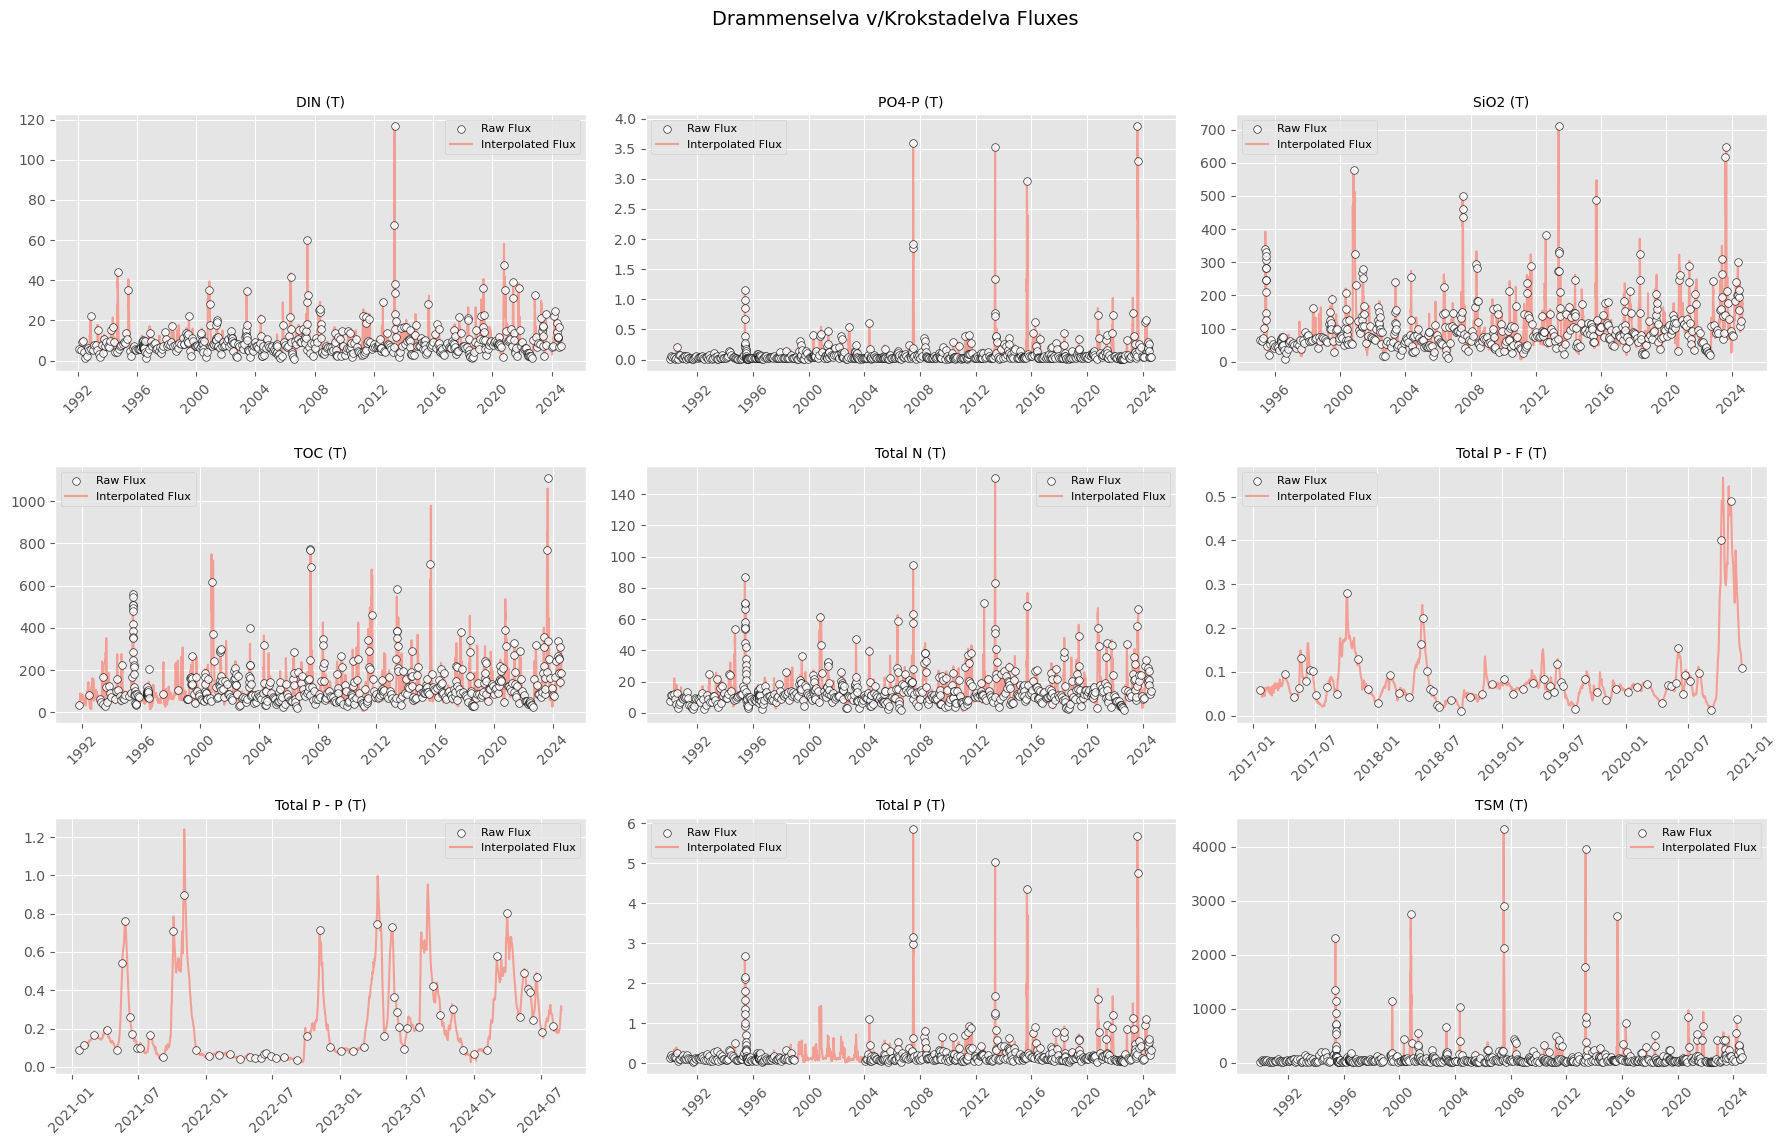

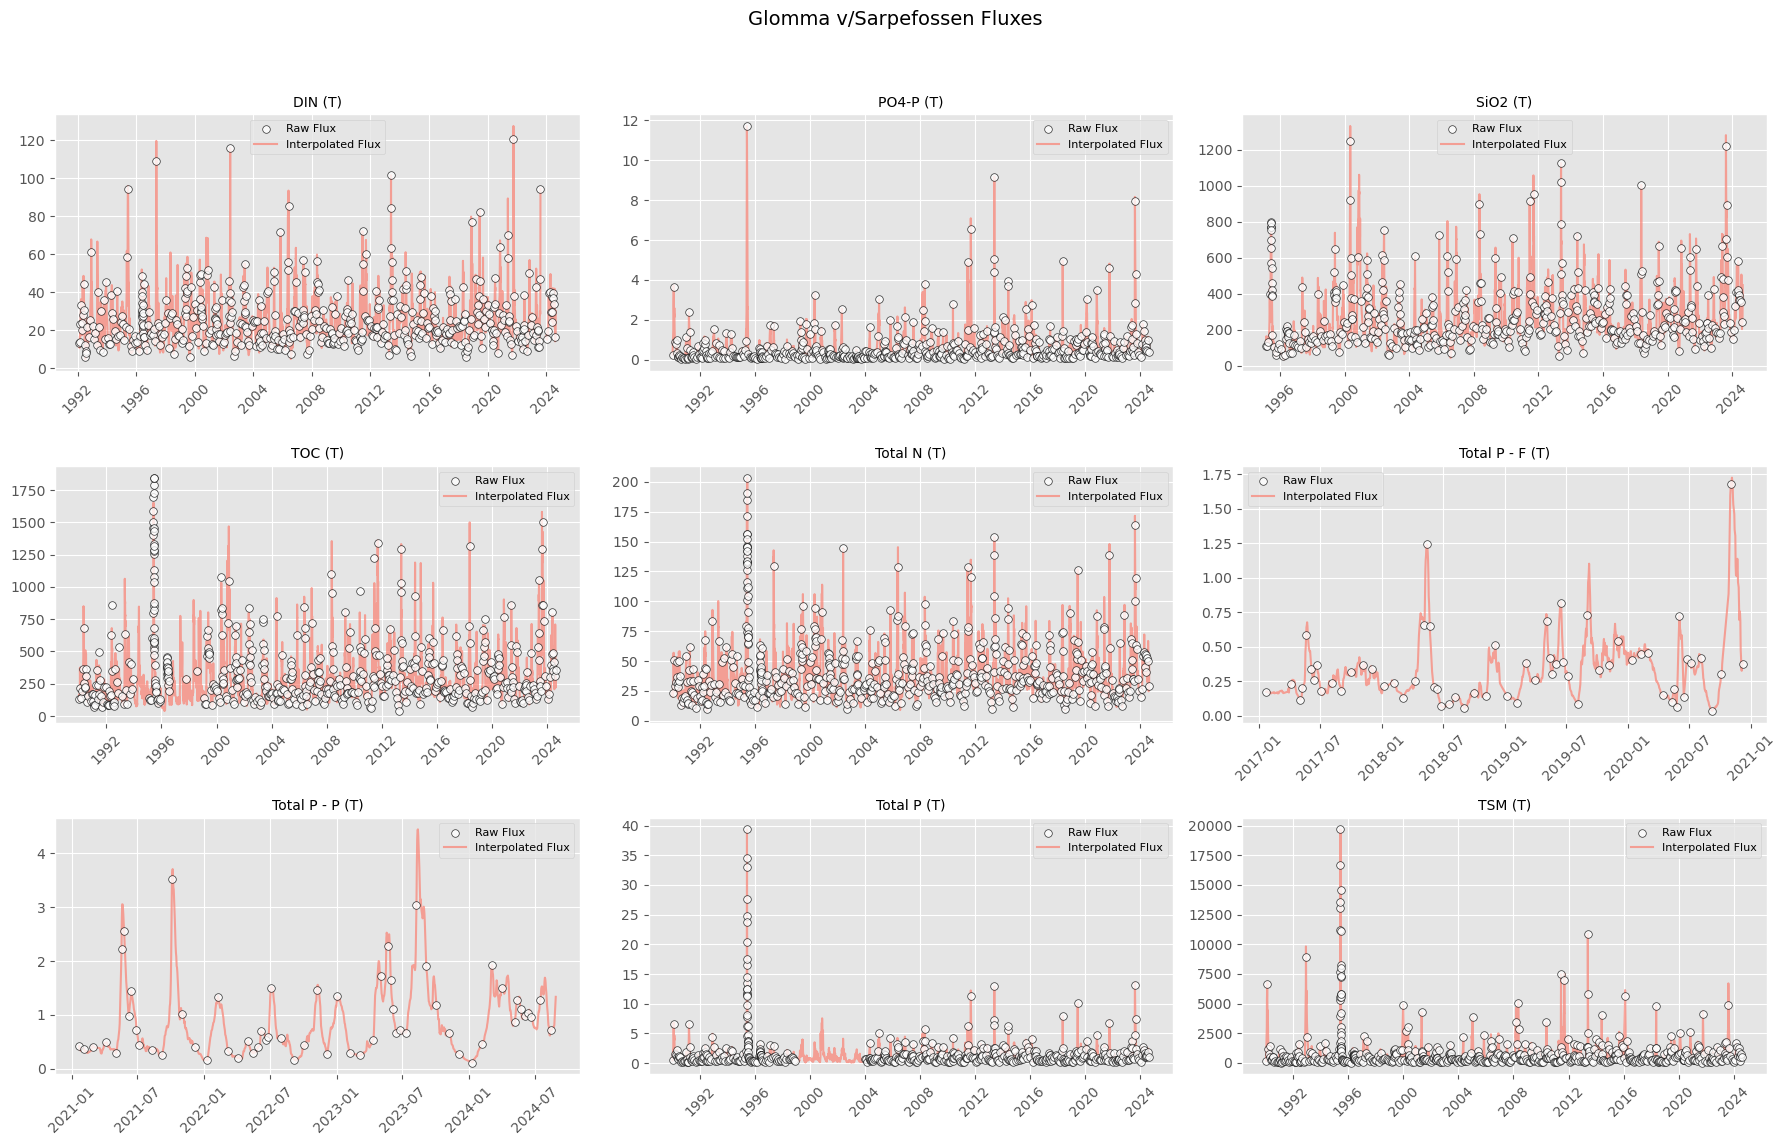

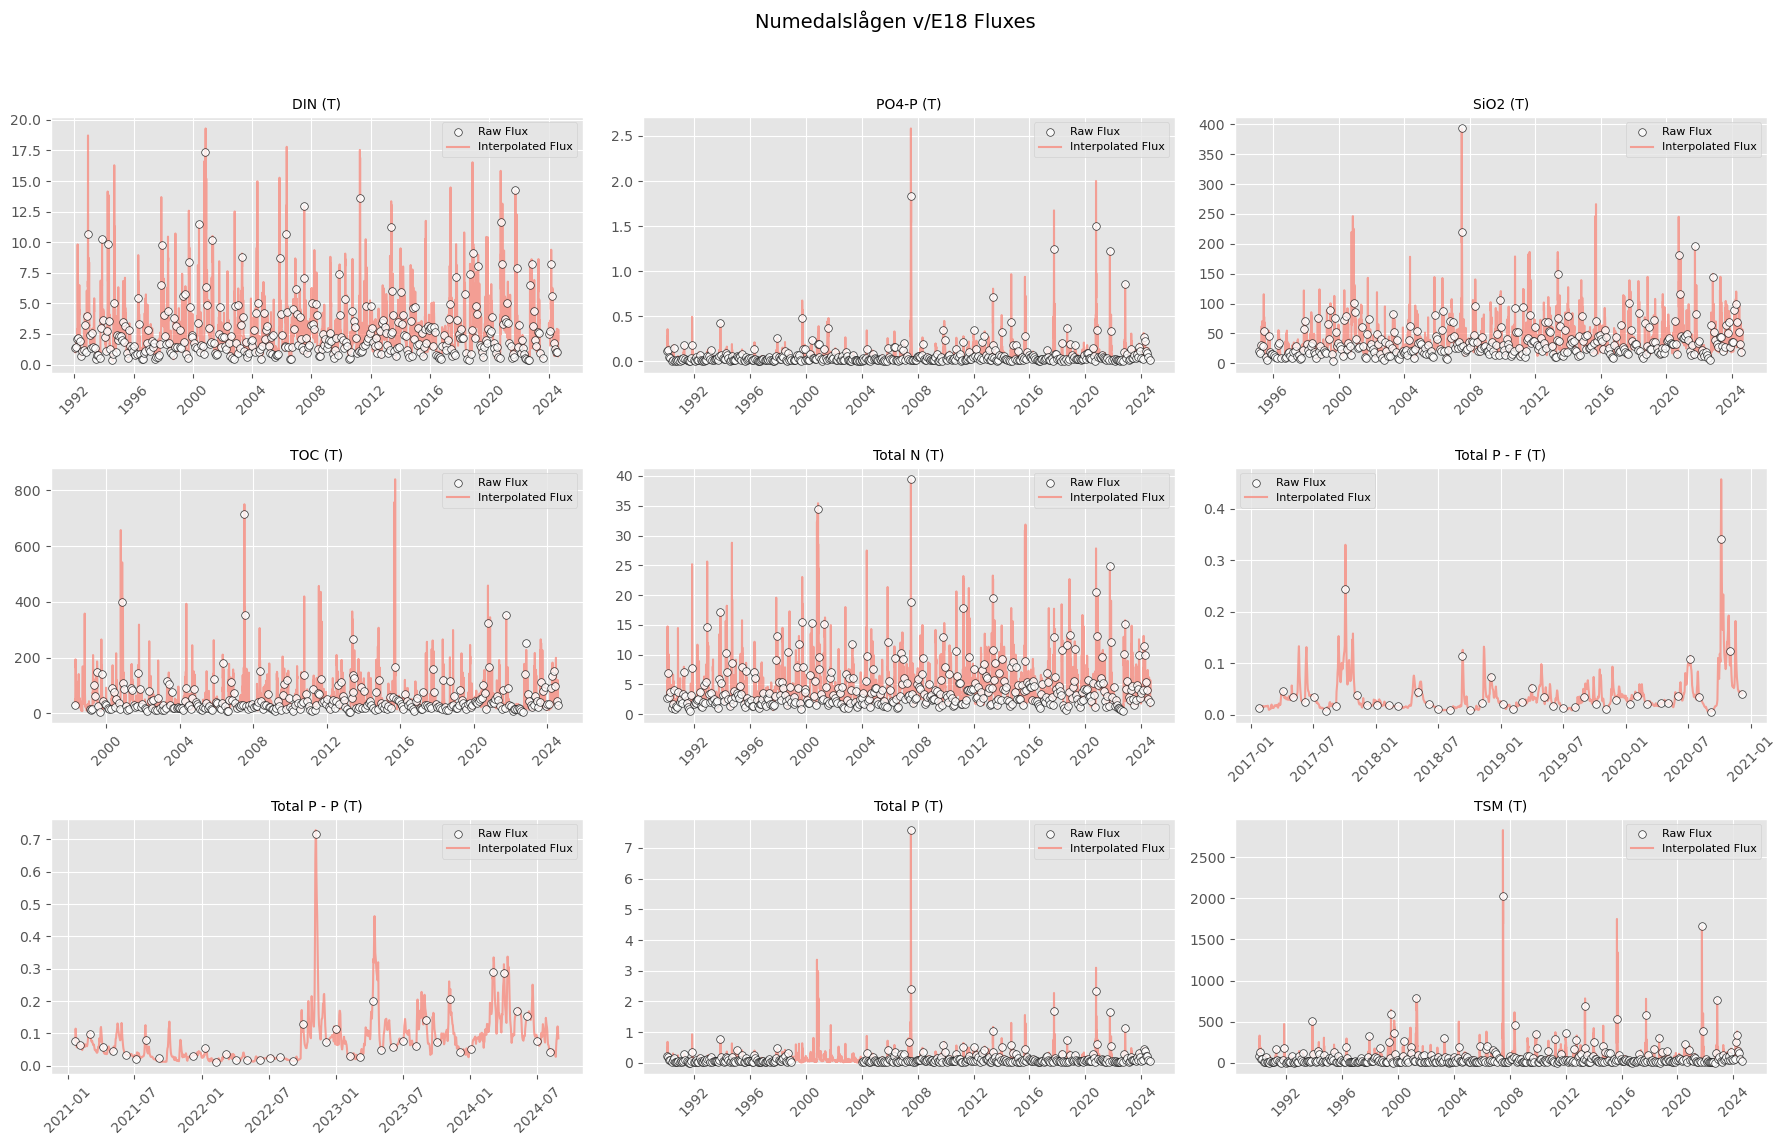

In [67]:
# Plot (LJB: to do: tidy and put in a function?)
# N.B. I changed the names for TOTP/F and TOTP_P, like we discussed earlier...
# Display names for axis labels
display_names = {
    'DIN_μg/l': 'DIN (T)',
    'PO4-P_µg/l': 'PO4-P (T)',  # LJB: This was TRP (total reactive P), right? Can you double-check and rename if that's right?
    'SiO2_mg/l': 'SiO2 (T)',
    'TOC_mg/l': 'TOC (T)',
    'TOTN_µg/l': 'Total N (T)',
    'TOTP/F_µg/l P': 'TDP (T)',
    'TOTP_P_µg/l P': 'Particulate P (T)',
    'TOTP_µg/l': 'Total P (T)',
    'TSM_mg/l': 'TSM (T)',
}


# Plot
for station_name, df_station in daily_flux_dict.items():

    vars_to_plot = list(display_names.keys())
    n_vars = len(vars_to_plot)
    n_cols = 3
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, var in enumerate(vars_to_plot):
        ax = axes[i]

        raw_flux_col = f"{var}_raw"
        proc_flux_col = f"{var}_est"

        if raw_flux_col not in df_station.columns and proc_flux_col not in df_station.columns:
            continue 

        # Plot flux raw data 
        if raw_flux_col in df_station.columns:
            ax.scatter(df_station.index, df_station[raw_flux_col],
                       label='Raw Flux', marker='o', facecolors='white', edgecolors='black',
                       s=30, alpha=0.8, zorder=4)

        # Plot flux interpolated data 
        if proc_flux_col in df_station.columns:
            ax.plot(df_station.index, df_station[proc_flux_col],
                    label='Interpolated Flux', linestyle='-', color='salmon', alpha=0.7, zorder=2)


        ax.set_title(display_names.get(var, var), fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend(fontsize=8)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{station_name} Fluxes", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Monthly and fluxes

In [79]:
monthly_flux_dict = {}
annual_flux_dict = {}

# LJB: I changed the min_periods, so we don't calculate monthly or annual fluxes when we don't have missing values in the month/year (to not low-bias the result)
# To do: add checks for gaps in daily data and interpolate if any are there. Shouldn't be though.

for site in site_li:
    
    # Monthly fluxes, and store in dict
    monthly_flux_df = daily_flux_dict[site].resample('ME').sum(min_count=25)  #min_count=1 means: require at least one non-NaN to compute the sum — otherwise, return NaN
    monthly_flux_dict[site] = monthly_flux_df

    # Annual fluxes, and store in dict. Note for annual we change the index from datetime to integer
    annual_flux_df = daily_flux_dict[site].resample('YE').sum(min_count=12)  #min_count=1 means: require at least one non-NaN to compute the sum — otherwise, return NaN
    annual_flux_df['Year'] = annual_flux_df.index.year
    annual_flux_df.set_index('Year', inplace=True)
    annual_flux_dict[site] = annual_flux_df

    # Save to csv
    # fpath = os.path.join(flux_folder, "monthly", f"monthly_fluxes_{short_site_li[site]}.csv")
    # monthly_flux_df.to_csv(fpath)

    # fpath = os.path.join(flux_folder, "annual", f"annual_fluxes_{short_site_li[site]}.csv")
    # annual_flux_df.to_csv(fpath)

In [78]:
annual_flux_df.tail()

Farge_mg Pt/l_raw  Farge_mg Pt/l_est  DIN_μg/l_raw  DIN_μg/l_est  \
Year                                                                     
2020                NaN                NaN     38.955017   1031.286093   
2021                NaN      124968.096753     44.445093    955.604245   
2022        4126.979635       81792.664669     27.879030    610.921063   
2023        4357.088323      143986.944283           NaN    499.488447   
2024                NaN      125538.086065           NaN    598.001040   

      PO4-P_µg/l_raw  PO4-P_µg/l_est  SiO2_mg/l_raw  SiO2_mg/l_est  \
Year                                                                 
2020        2.408471       45.592036     681.329496   17493.154021   
2021        1.893792       27.348224     611.302105   13512.529054   
2022        1.098806       17.832202     410.584705    8878.544642   
2023        0.825669       26.601865     476.036056   15944.690602   
2024             NaN       19.693408            NaN   11440.861868   

      TOC_mg/l_raw  TOC_mg/l_est  ...  TOTP_P_µg/l P_raw  TOTP_P_µg/l P_est  \
Year                              ...                                         
2020    991.612005  22503.904175  ...                NaN                NaN   
2021    867.709895  15889.352726  ...                NaN          16.241343   
2022    598.993263   9788.677814  ...           1.139168          20.820333   
2023    611.908137  20866.120547  ...           1.082530          35.007444   
2024           NaN  13502.632473  ...                NaN          30.160601   

      TOTP_µg/l_raw  TOTP_µg/l_est  TSM_mg/l_raw  TSM_mg/l_est  \
Year                                                             
2020       3.989265      77.855453           NaN  21362.831255   
2021       2.931920      46.936509   2344.867223  31130.579169   
2022       1.799642      32.001752   1063.886613  17467.547041   
2023       1.558197      49.775534    679.376985  21937.392475   
2024            NaN      38.868486           NaN  24324.610004   

      UV-Abs. 410nm_Abs/cm_raw  UV-Abs. 410nm_Abs/cm_est  \
Year                                                       
2020               3869.904233              87455.471073   
2021               3258.673072              61073.927843   
2022               2339.533591              39080.315904   
2023               2394.936350              72441.127961   
2024                       NaN                       NaN   

      UV-Abs. 254nm_Abs/cm_raw  UV-Abs. 254nm_Abs/cm_est  
Year                                                      
2020              39103.211570             889178.213680  
2021              32913.503802             621722.375426  
2022              23660.019528             402488.272764  
2023              24461.214475             738263.129598  
2024                       NaN                       NaN  

[5 rows x 24 columns]

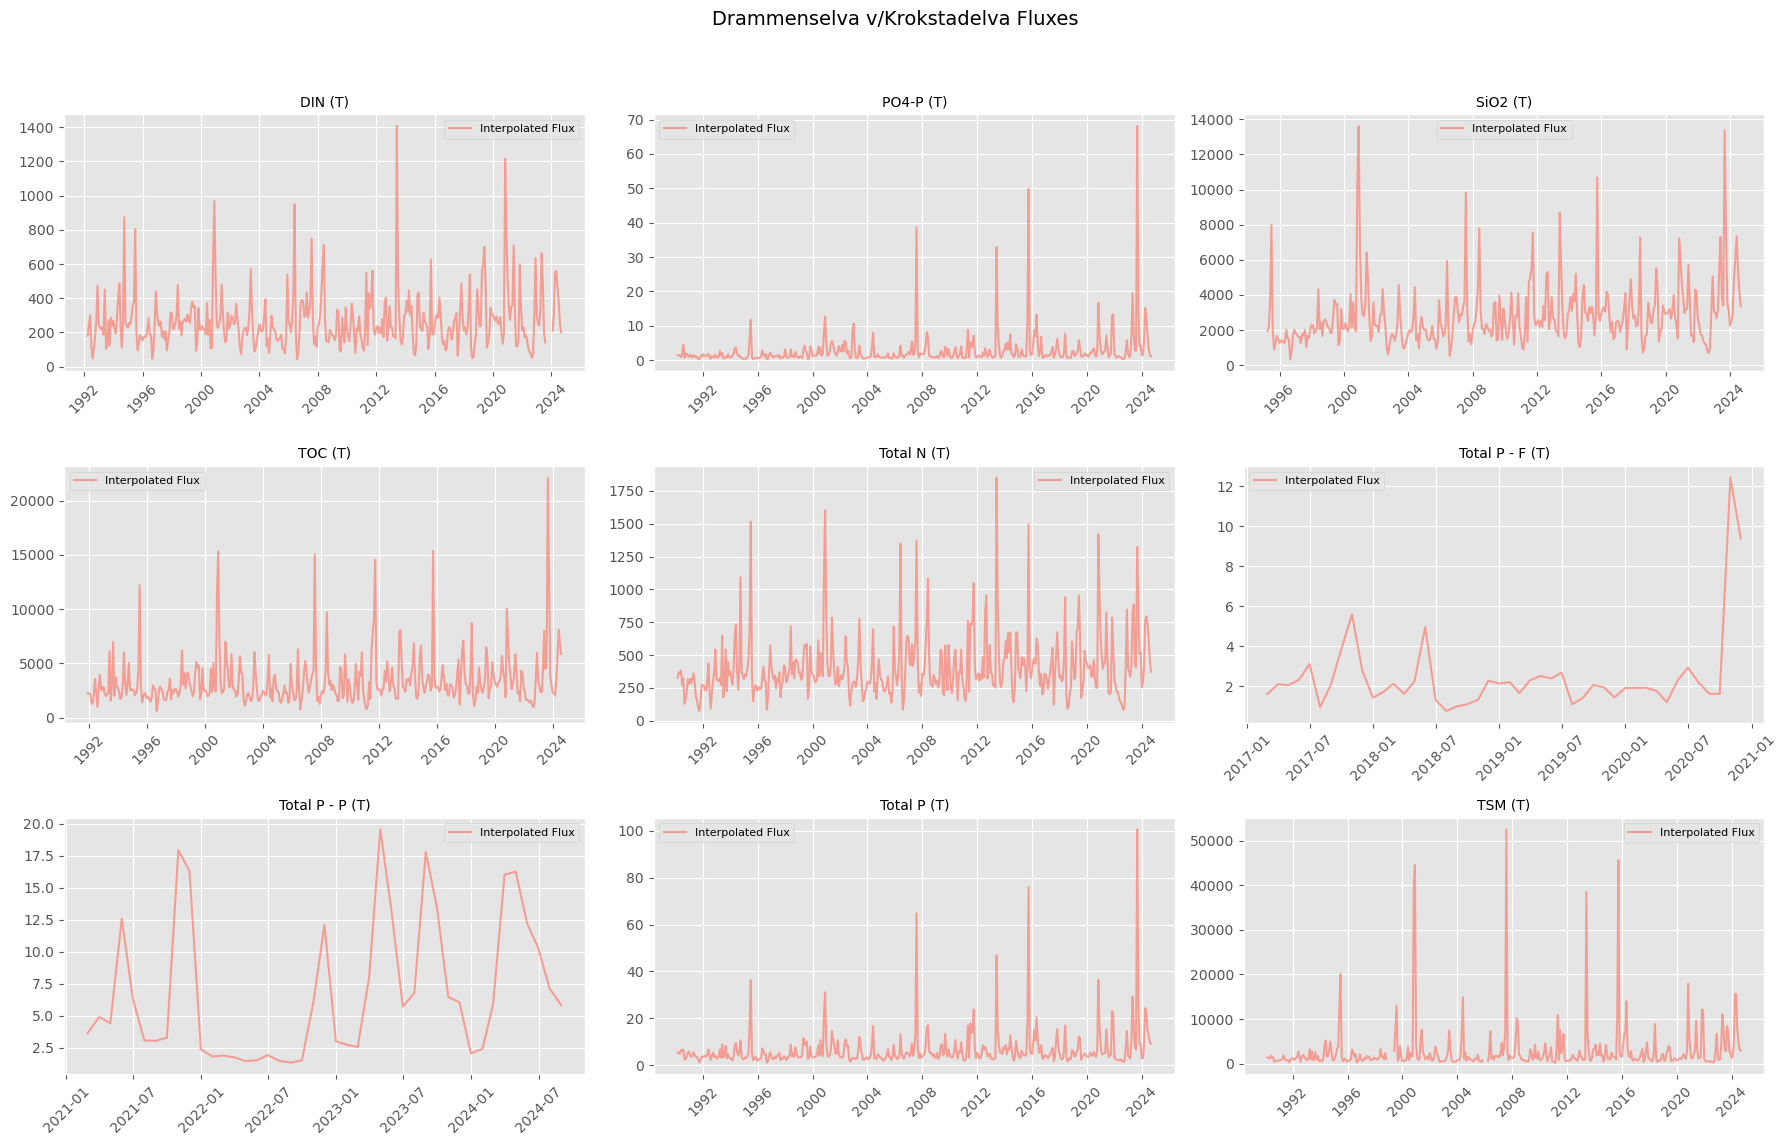

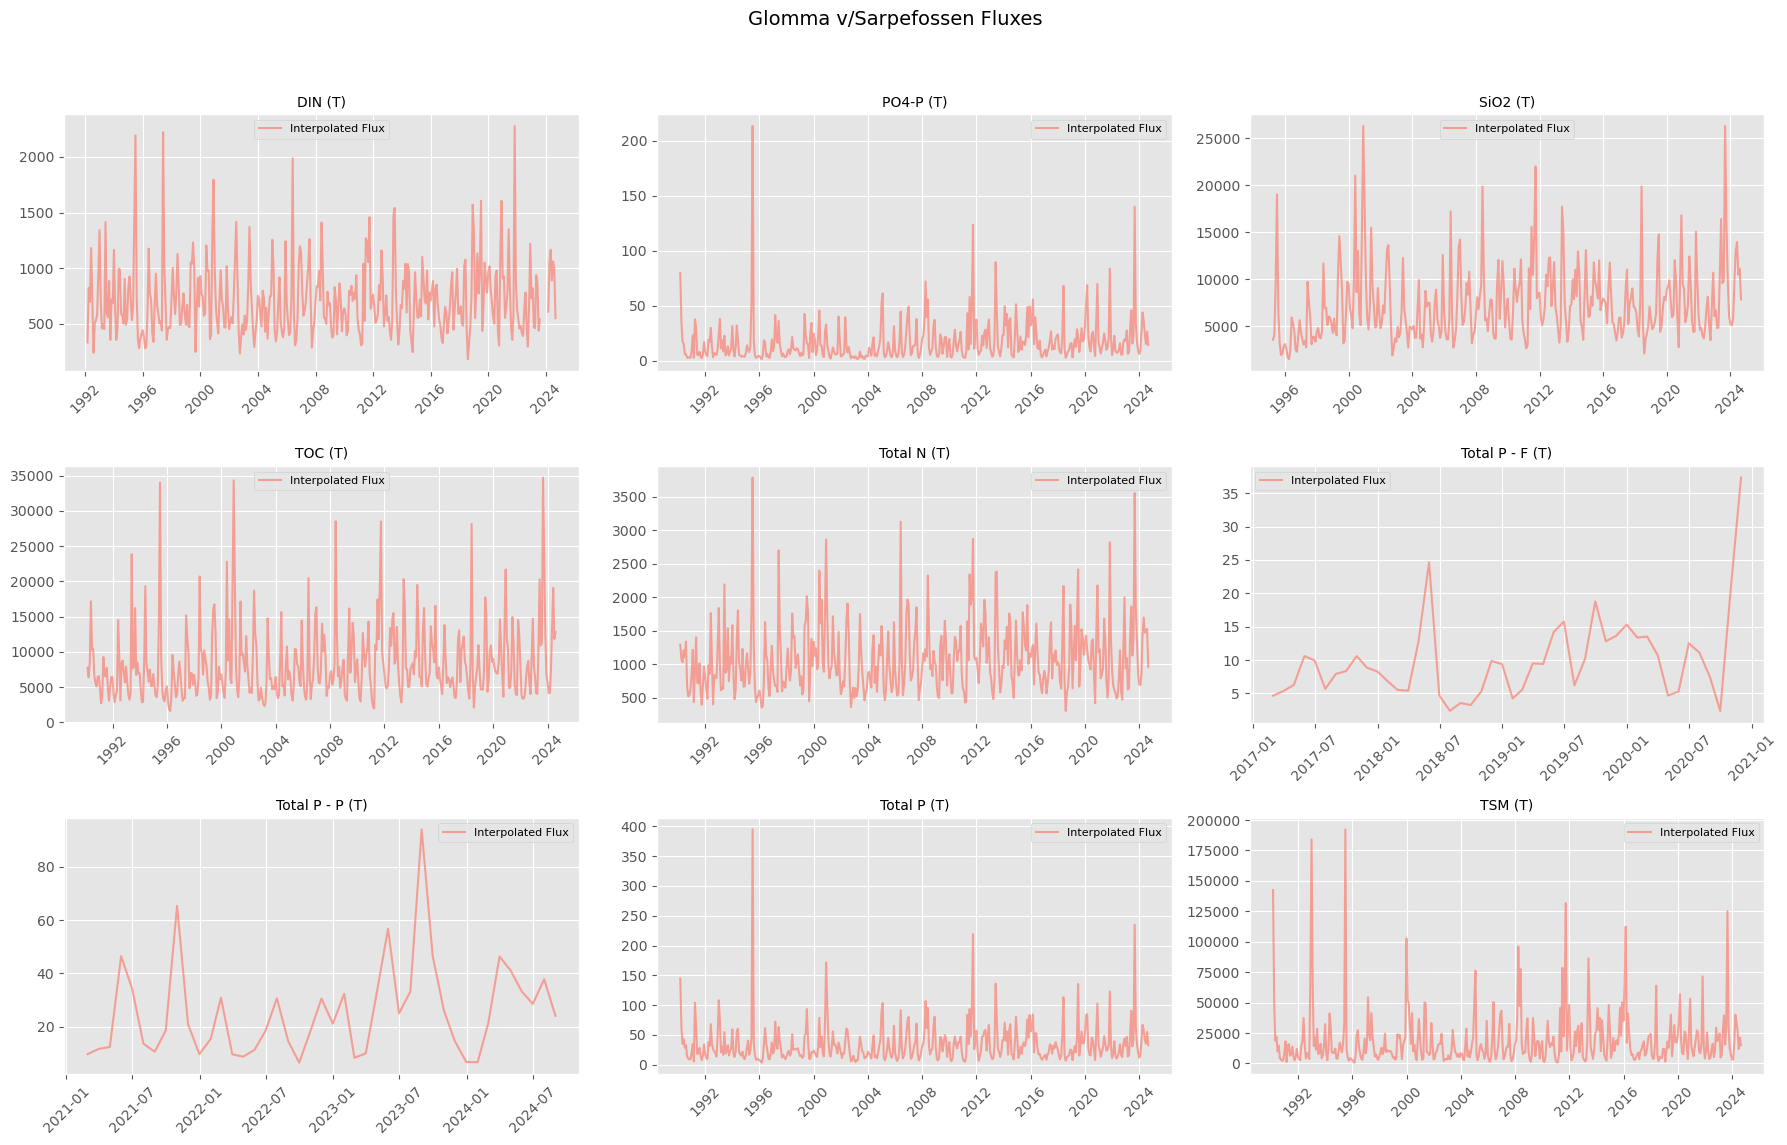

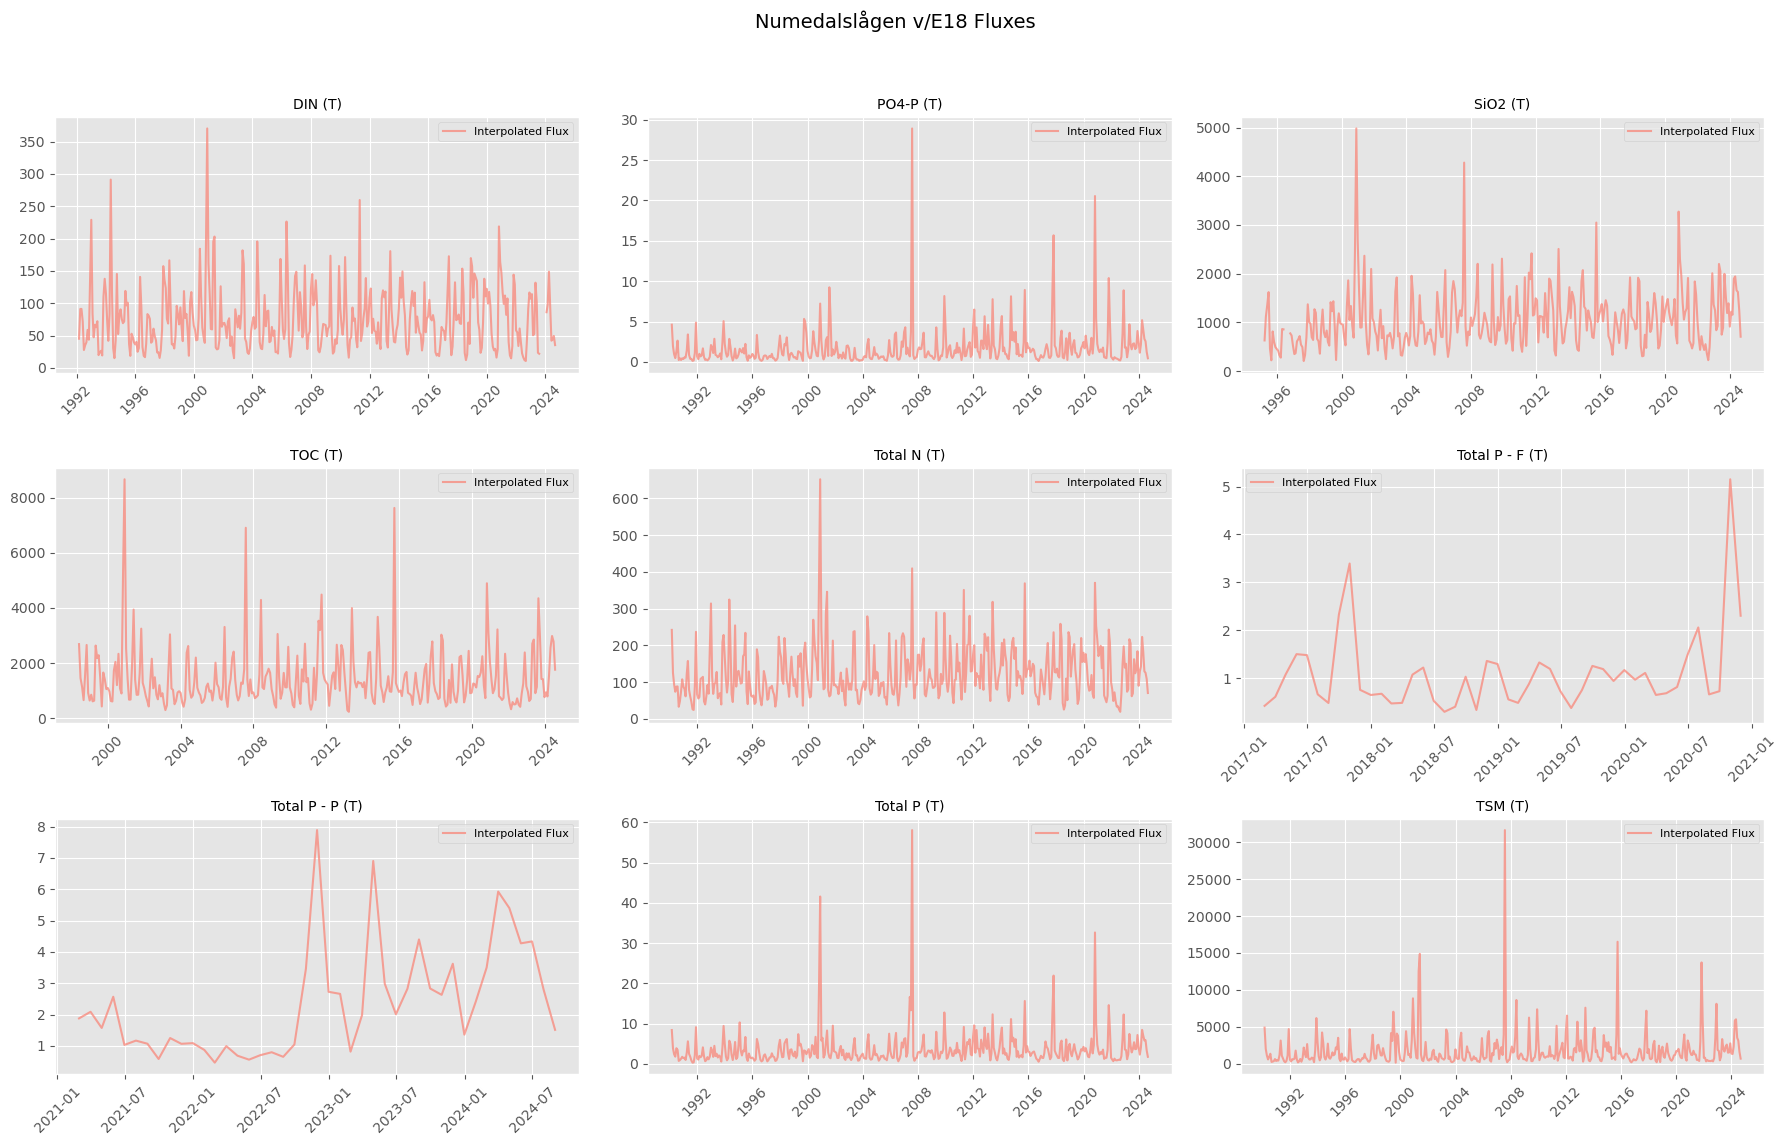

In [80]:
# Plot monthly
plt.close('all')  # Close any interactive plots above
for station_name, df_station in monthly_flux_dict.items():
    
    vars_to_plot = list(display_names.keys())
    n_vars = len(vars_to_plot)
    n_cols = 3
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, var in enumerate(vars_to_plot):
        ax = axes[i]
        
        proc_flux_col = f"{var}_est"

        if raw_flux_col not in df_station.columns and proc_flux_col not in df_station.columns:
            continue  

        if proc_flux_col in df_station.columns:
            ax.plot(df_station.index, df_station[proc_flux_col],
                    label='Interpolated Flux', linestyle='-', color='salmon', alpha=0.7, zorder=2)

        # Set title and labels
        ax.set_title(display_names.get(var, var), fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend(fontsize=8)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{station_name} Fluxes", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


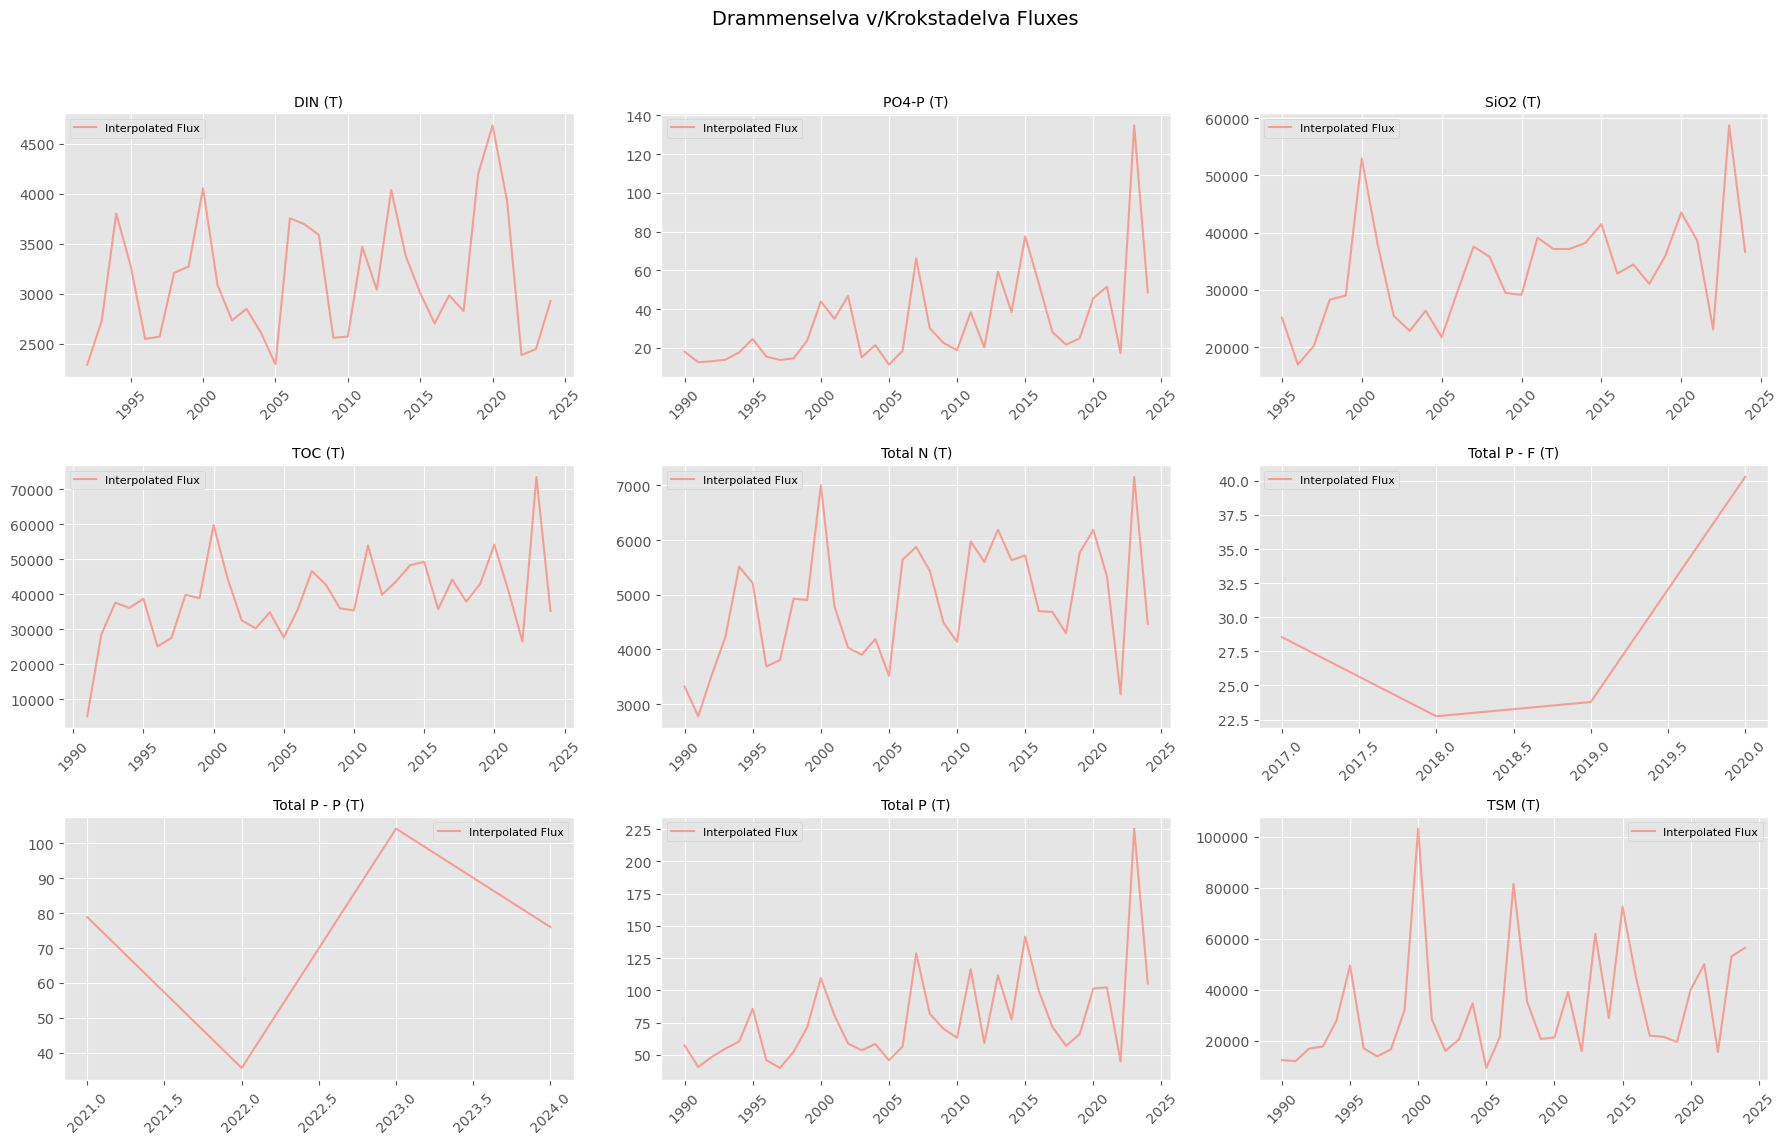

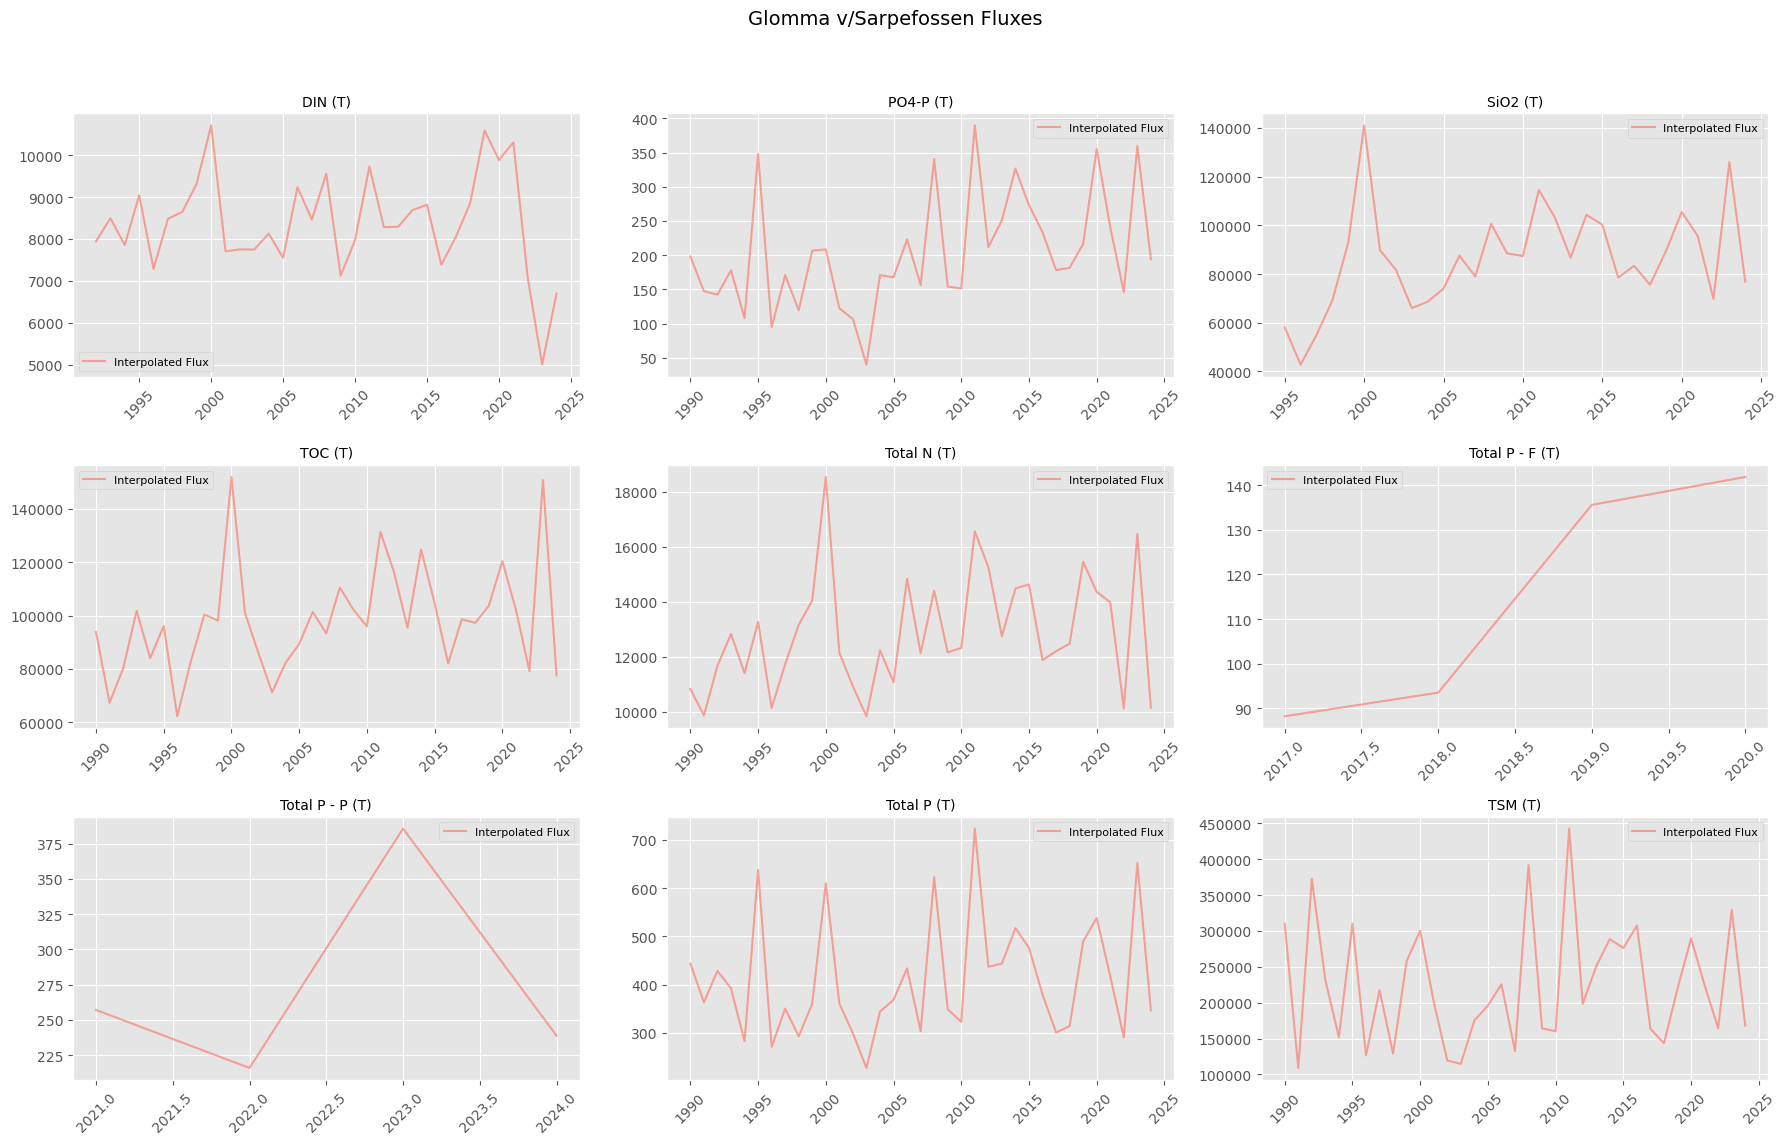

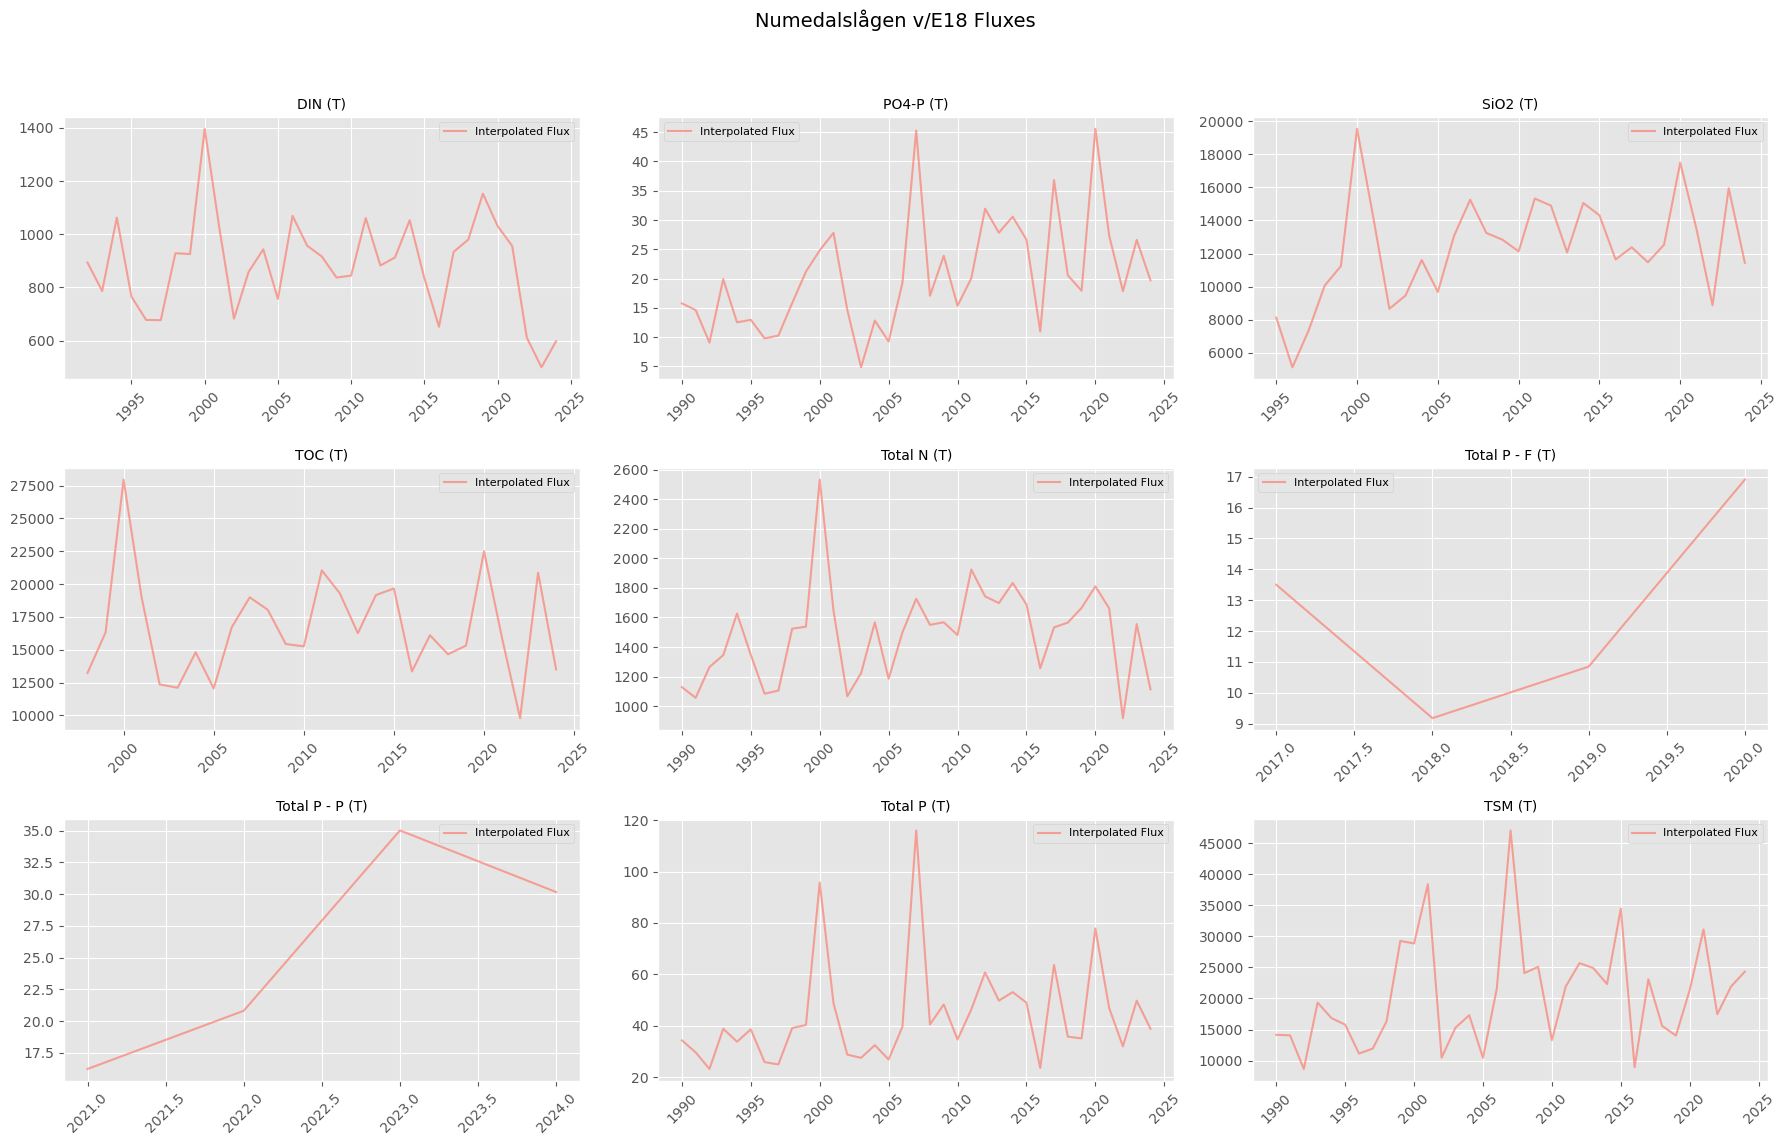

In [81]:
# Plot annual
for station_name, df_station in annual_flux_dict.items():

    vars_to_plot = list(display_names.keys())
    n_vars = len(vars_to_plot)
    n_cols = 3
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, var in enumerate(vars_to_plot):
        ax = axes[i]

        proc_flux_col = f"{var}_est"

        if raw_flux_col not in df_station.columns and proc_flux_col not in df_station.columns:
            continue 

        if proc_flux_col in df_station.columns:
            ax.plot(df_station.index, df_station[proc_flux_col],
                    label='Interpolated Flux', linestyle='-', color='salmon', alpha=0.7, zorder=2)

        # Set title and labels
        ax.set_title(display_names.get(var, var), fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend(fontsize=8)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{station_name} Fluxes", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
